In [1]:
#Import functions createdon my side
from Functions_custo_by_Nico import * 
#import seaborn
#from matplotlib.image import imread

import cv2
import albumentations as A

import segmentation_models as sm #Check here: https://segmentation-models.readthedocs.io/en/latest/api.html
# calling functions
Test_Imported_Functions()

Segmentation Models: using `tf.keras` framework.
Functions have been properly imported !


In [2]:
import skimage.io as io
import skimage.transform as trans

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import categorical_crossentropy, binary_crossentropy
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Model


import segmentation_models as sm

# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50

## Chargement des données

Nous lisons le fichier CSV qui liste nos données d'entrées (pandas dataframe)

In [3]:
clean_df = pd.read_csv('./clean_df.csv')
clean_df.head()

,Unnamed: 0,Phase,City,File_x,Path_x,File_id1,File_id2,File_type_x,File_unique_index,File_y,Path_y,File_type_y
0,0,test,berlin,berlin_000000_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,0,19,leftImg8bit.png,berlin_000000_000019,berlin_000000_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine
1,1,test,berlin,berlin_000001_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,1,19,leftImg8bit.png,berlin_000001_000019,berlin_000001_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine
2,2,test,berlin,berlin_000002_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,2,19,leftImg8bit.png,berlin_000002_000019,berlin_000002_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine
3,3,test,berlin,berlin_000003_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,3,19,leftImg8bit.png,berlin_000003_000019,berlin_000003_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine
4,4,test,berlin,berlin_000004_000019_leftImg8bit.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,4,19,leftImg8bit.png,berlin_000004_000019,berlin_000004_000019_gtFine_labelIds.png,c:\Users\blanc\OpenClassrooms\IA_Project8_Open...,gtFine


In [4]:
len(clean_df.loc[clean_df['Phase'] == 'val'])

500

## Data Generator

Nous générons nos données d'entrainement et de test, en prenant en considérations les variables suivantes:
 - n_sample : si l'on souhaite réduire la taille du jeu de données
 - batch_size : la taille de batch
 - resize : Largeur et Hauteur
 - augmentation : utilise la librairie albumentation

In [5]:
# Data Loader preparation
n_sample = None #500 #Pour les tests, nous limitons le jeu de données à 20 images
batch_size = 5 #Pour les tests, nous limitons le batch_size à 2 images
resize_width = 256
resize_height = 128
# Declare an augmentation pipeline
augmentation = None 
# augmentation = A.Compose(
#                     [#A.RandomCrop(width=512, height=256), 
#                     A.Rotate(25),
#                     A.OneOf([A.RGBShift(), A.HueSaturationValue()]),
#                     #A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0), 
#                     #A.IAAPerspective(p=0.5), 
#                     #A.HorizontalFlip(p=0.5),
#                     A.OneOf([A.CLAHE(), A.RandomBrightnessContrast(), A.RandomGamma()]), 
#                     ])


# Generators
train_generators = GeneratorCitySpace(clean_df, n_sample, batch_size, resize_width, resize_height, 'train', augmentation)
val_generators = GeneratorCitySpace(clean_df, n_sample, batch_size, resize_width, resize_height, 'val', augmentation)
test_generators = GeneratorCitySpace(clean_df, n_sample, batch_size, resize_width, resize_height, 'test', augmentation)

# #Autres Generator from Keras
# #Tuto here: https://vijayabhaskar96.medium.com/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1
# #Doc here: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe
# from keras_preprocessing.image import ImageDataGenerator

In [6]:
print(train_generators[0][1].shape)
print(np.unique(train_generators[0][1]))
print(train_generators[0][0].shape)

(5, 128, 256, 8)
[0. 1.]
(5, 128, 256, 3)


In [7]:
len(train_generators)

595

# Chargement du modèle UNET

U-NET est un modèle de réseau de neurones convolutif dédié aux taches de Vision par Ordinateur (Computer Vision) et plus particulièrement aux problèmes de Segmentation Sémantique

La segmentation sémantique consiste à étiqueter chaque pixel d’une image avec une classe correspondante:
 1. void
 2. flat
 3. construction
 4. object
 5. nature
 6. sky
 7. human
 8. vehicle

L'objectif est donc de génèrer à partir d'une image, un masque sur lequel chaque pixel est classifié.

L’architecture de U-NET est composée de deux chemins (architecture en U):
 - **Contraction = Encoder :** Capturer le contexte d’une image.
 - **Expansion = Decoder :** Localise grâce à la convolution transposée.

Cette architecture préserve la taille initiale = la taille de sortie est égale à la taille d’entrée.


In [8]:

n_filters = 32 #Variable used in Neural Network Convolutions steps
nb_class = 8
#Load model architecture
model_test = build_unet_block((resize_height, resize_width, 3), nb_class, n_filters)

# Inspiré de https://github.com/hlamba28/UNET-TGS/blob/master/
#model_test = get_unet(Input((resize_width, resize_height, 3), name='img'), n_filters=n_filters, dropout=0.05, batchnorm=True)

#Load model architecture
#model_test = build_unet((resize_height, resize_width, 3), nb_class, n_filters)

## Evaluation de la performance

Quelques références:
 - [Article on Semantic Segmentation Metrics](https://ilmonteux.github.io/2019/05/10/segmentation-metrics.html)
 - [DICE vs IOU](https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou)
 - [towardsdatascience article - restricted](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2)
 - [Kaggle sur les métriques - Inclu MultiClass](https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics?scriptVersionId=92089547&cellId=58)

Une documentation sur les fonctions de coûts pour la segmentation d'images est [disponible ici](https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html)

Durant les phases de développement, nous avons conduit une approche itérative nous permettant de choisir:
 1. les **meilleures métriques** associés au besoin métier.
 2. les **meilleures fonctions de coûts**.

De ce fait, voici ci-desssous un tableau récapitulatif des modèles entrainés et étudiés.
Rappelons que : **Loss = 1 - Metric**

Suite à l'analyse de ces critères, nous vous présenterons ci-dessous les modèles ayant été entrainé avec le couple:
 - Fonction de coût = CAT FOCAL LOSS (customisé)
 - Métriques = IOU & F1_Score

| Etape | Fonction de coût | Métriques | Formule basée sur la matrice de confusion | Avantages | Inconvénients|
|---|------|--------|------|-----|------|
|1| Categorical Cross-entropy | [Pixel Accuracy](https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics?scriptVersionId=92089547&cellId=4) | $ \frac{TP + TN}{TP + FP + TN + FN} $ | Fonction de cout de base, facile à intepreter | Fonction de cout non adaptée à des datasets déséquilibrés, Métrique peu pertinente au regard du besoin |
|1| Categorical Cross-entropy | [DICE (F1-score)](https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics?scriptVersionId=92089547&cellId=27) | $ \frac{2 TP}{2 TP + FP + FN} $ | Métrique utile pour les classes déséquilibrées. | Moins stricte sur les vrais négatifs que IOU |
|1| Categorical Cross-entropy | Intersection over Union ([IoU]((https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics?scriptVersionId=92089547&cellId=30))) | $ \frac{TP}{TP + FP + FN} $ | Métrique utile pour les classes déséquilibrées. | Plus stricte sur les vrais négatifs que DICE |
|2| Jaccard (IOU) | IoU & DICE scores | $ \frac{TP}{TP + FP + FN} $ & $ \frac{2 TP}{2 TP + FP + FN} $  | Analyse de similarité | xxx |
|2| [Dice](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) | IoU & DICE scores | $ \frac{TP}{TP + FP + FN} $ & $ \frac{2 TP}{2 TP + FP + FN} $  | Dice Loss Fonctionne bien sur les images, par analyse du chevauchement | Peu adapté à la segmentation par pixel |
|2| [Categorical Focal Loss](https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html#3) | IoU & DICE scores | $ \frac{TP}{TP + FP + FN} $ & $ \frac{2 TP}{2 TP + FP + FN} $  | Focal Loss gère bien la segmentation de cas complexe | Surtout utile pour des datasets très désequilibrés |
|3| Categorical Cross-entropy + [Dice](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) | [IoU](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU) & F1 Score (DICE Score) | $ \frac{TP}{TP + FP + FN} $ & $ \frac{2 TP}{2 TP + FP + FN} $ | Facile à interpreter. Gère bien les classes déséquilibrées. | xxx |
|3| Categorical Focal Loss + [Dice](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) | [IoU](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU) & F1 Score (DICE Score) | $ \frac{TP}{TP + FP + FN} $ & $ \frac{2 TP}{2 TP + FP + FN} $ | Facile à interpreter. Gère bien les classes déséquilibrées. | xxx |



In [11]:
# Ffrom Kaggle https://www.kaggle.com/code/michaelcripman/road-segmentation-unet-keras-implementation
# Or From GitHub : https://github.com/srihari-humbarwadi/cityscapes-segmentation-with-Unet/blob/master/batch_training.py
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.cast(K.flatten(y_true), K.floatx()) #K.flatten(y_true) #
    y_pred_f = K.cast(K.flatten(y_pred), K.floatx()) #K.flatten(y_pred) #
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def total_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + (3*dice_loss(y_true, y_pred))
    return loss
    
#metrics=[dice_coeff(y_true, y_pred), tf.keras.metrics.MeanIoU(30, name = 'iou')]
#metrics=[dice_coeff, 'accuracy']


### Configuration du modèle

Voici ci-dessous quelques détails sur notre modèle UNET : (Voir fichier de fonctions: Functions_custo_by_Nico.py pour plus de détails)
 - **Premier Bloc :** 4 Couches de double-convolution avec maxpooling 2x2 et fonction d'activation ReLU - Normalisation 
 - **Pont :** Double-convolution
 - **Second Bloc :** Sur-échantillonnage (upsampling) de la carte des caractéristiques suivie d'une couche de convolution 2x2 transposée (skip connections) + double-convolution avec fonction d'activation ReLU
 - **La Sortie :** Dernière couche de convolution, avec fonction d'activation softmax pour classifier chaque pixel sur 8 classes

Nous définissons un Learning Rate initial de 1e-3.

Nous selectionnerons les métriques présentes ci-dessous.

In [9]:
# Fit model
learning_rate = 1e-3
# define optimizer
optim = keras.optimizers.Adam(learning_rate)

# Select Metric
#metrics=['accuracy']                           #Métrique = Etape 1
#metrics = [sm.metrics.FScore()]                #Métrique = Etape 1
#metrics = [sm.metrics.IOUScore()]              #Métrique = Etape 1
metrics = [sm.metrics.FScore(), sm.metrics.IOUScore()] #Métriques = Choix final = Mesures de 2 métriques

# Select Loss function
#loss_function = 'categorical_crossentropy'     #Loss = Etape 1 : Construction de la baseline  : Fonction de cout non pertinente au regard du besoin métier, car gère mal les classes déséquilibrés
#loss_function = sm.losses.CategoricalCELoss()  #Loss = Etape 1 : Construction de la baseline (Utilisation de la librairie segmentation model)

#loss_function = sm.losses.DiceLoss()           #Loss = Etape 2
#loss_function = sm.losses.JaccardLoss()         #Loss = Etape 2
#loss_function = sm.losses.CategoricalFocalLoss()#Loss = Etape 2

#loss_function = (0.5 * sm.losses.CategoricalFocalLoss()) + sm.losses.DiceLoss()    #Loss Combination = Choix final 
#loss_function = (0.5 * sm.losses.CategoricalCELoss()) + sm.losses.DiceLoss()       #Loss Combination
#loss_function = (0.5 * sm.losses.CategoricalCELoss()) + sm.losses.JaccardLoss()    #Loss Combination   === A FAIRE
loss_function = sm.losses.cce_jaccard_loss # = categorical_crossentropy + jaccard_loss #Loss Combination   === A FAIRE
#loss_function = sm.losses.categorical_focal_dice_loss # = categorical_focal_loss + dice_loss   #Loss Combination   === A FAIRE
#loss_function = sm.losses.categorical_focal_jaccard_loss # = categorical_focal_loss + jaccard_loss #Loss Combination   === A FAIRE

#loss_function = total_loss
#loss_function = total_loss                      #Loss = Choix Loss customisée (sans librairie)

model_test.compile(optimizer=optim, loss=loss_function, metrics=metrics) 

model_test.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 128, 32)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
(len(clean_df.loc[clean_df['Phase'] == 'train']) // batch_size)
#n_sample // batch_size

595

## Entrainement du modèle

Nous utiliserons les [callbacks](https://towardsdatascience.com/keras-callbacks-and-how-to-save-your-model-from-overtraining-244fc1de8608) pour éviter le sur-entrainement, et sauvegarder le modèle Keras ou les poids du modèle à une certaine fréquence lors de son entrainement:
 - [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) : Surveillance de la métrique, et arrèt de l'entrainement si l'arrêt de la progression est confirmée
 - [Checkpoint](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) : Sauvegarde le meilleur modèle, au regard de la métrique IOU sur le jeu de validation
 - [Reduce LR on Plateau](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) : Réduit le Learning Rate lorsque la métrique ne s'améliorer plus

Nous définissons un nombre d'epochs de 50 maximum.

In [11]:
# callbacks that will be used during training
#earlystopper = EarlyStopping(monitor='val_loss', mode = 'min', patience=5) #ou  (patience=10, verbose=1, mode = 'auto') 
earlystopper = EarlyStopping(patience=10, verbose=1, mode = 'auto')

#checkpoint = ModelCheckpoint(filepath = './Models/checkpoints/weights.h5', verbose=True, save_best_only=True) #monitor='loss' ou monitor='val_iou_score' #mode='max' #filepath='model.{epoch:02d}-{val_loss:.2f}.h5'
checkpoint = ModelCheckpoint(filepath = './Models/checkpoints/weights.h5', verbose=True, save_best_only=True, monitor='val_iou_score', mode='max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4)
reduce_lr = ReduceLROnPlateau(factor=0.1, cooldown= 10, patience=10, verbose=1, min_lr=1e-5)

#tensorboard = TensorBoard(log_dir='./Models/logs', write_graph=True)

n_epochs = 50

#Train model
# results = model_test.fit_generator(
#                             train_generators, 
#                             validation_data = val_generators, 
#                             #validation_steps = (len(clean_df.loc[clean_df['Phase'] == 'val']) // batch_size), #(n_sample // batch_size), #
#                             #steps_per_epoch = (len(clean_df.loc[clean_df['Phase'] == 'train']) // batch_size), #(n_sample // batch_size), #
#                             validation_steps = (n_sample // batch_size), 
#                             steps_per_epoch = (n_sample // batch_size), 
#                             epochs = n_epochs, 
#                             workers=4,
#                             verbose = 1,
#                             use_multiprocessing=True,
#                             callbacks = [checkpoint, reduce_lr, earlystopper], #, reduce_lr
#                             #class_weight  : This can be useful to tell the model to "pay more attention" to samples from an under-represented class. 
#                             #max_queue_size  :  Maximum size for the generator queue. Default to 10
#                             )

results = model_test.fit(
                        train_generators, 
                        validation_data = val_generators, 
                        validation_steps = (len(clean_df.loc[clean_df['Phase'] == 'val']) // batch_size), #
                        steps_per_epoch = (len(clean_df.loc[clean_df['Phase'] == 'train']) // batch_size), #
                        epochs = n_epochs, 
                        workers=4,
                        verbose = 1,
                        #use_multiprocessing=True,
                        callbacks = [checkpoint, reduce_lr, earlystopper], #, reduce_lr
                        #class_weight  : This can be useful to tell the model to "pay more attention" to samples from an under-represented class. 
                        #max_queue_size  :  Maximum size for the generator queue. Default to 10
                        )

Epoch 1/50
595/595 [==============================] - ETA: 0s - loss: 0.7820 - f1-score: 0.4531 - iou_score: 0.3474WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0105s vs `on_test_batch_end` time: 0.0894s). Check your callbacks.

Epoch 00001: val_iou_score improved from -inf to 0.44169, saving model to ./Models/checkpoints\weights.h5
595/595 [==============================] - 105s 177ms/step - loss: 0.7820 - f1-score: 0.4531 - iou_score: 0.3474 - val_loss: 0.6677 - val_f1-score: 0.5500 - val_iou_score: 0.4417
Epoch 2/50
595/595 [==============================] - ETA: 0s - loss: 0.6161 - f1-score: 0.5926 - iou_score: 0.4819
Epoch 00002: val_iou_score improved from 0.44169 to 0.49644, saving model to ./Models/checkpoints\weights.h5
595/595 [==============================] - 131s 220ms/step - loss: 0.6161 - f1-score: 0.5926 - iou_score: 0.4819 - val_loss: 0.6023 - val_f1-score: 0.6080 - val_iou_score: 0.4964
Epoch 3/50
595/595 [==

In [20]:
def display_learning_curves_iou_dice(history, model_name):
    iou = history.history["iou_score"]
    val_iou = history.history["val_iou_score"]

    fscore = history.history["f1-score"]
    val_fscore = history.history["val_f1-score"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range=range(1, len(iou) + 1)
    #epochs_range = range(n_epochs)

    fig = plt.figure(figsize=(15,5))
    plt.grid(color='white')

    plt.subplot(1,3,1)
    plt.plot(epochs_range, iou, 'g', label="train iou_score")
    plt.plot(epochs_range, val_iou, 'c', label="validataion iou_score")
    plt.title("iou_score")
    plt.xlabel("Epoch")
    plt.ylabel("iou_score")
    plt.legend(loc="upper left")

    plt.subplot(1,3,2)
    plt.plot(epochs_range, fscore, 'g', label="train Dice coeff")
    plt.plot(epochs_range, val_fscore, 'c', label="validataion Dice coeff")
    plt.title("f1-score or Dice coeff")
    plt.xlabel("Epoch")
    plt.ylabel("f1-score")
    plt.legend(loc="upper left")

    plt.subplot(1,3,3)
    plt.plot(epochs_range, loss, 'g', label="train loss")
    plt.plot(epochs_range, val_loss, 'c', label="validataion loss")
    plt.title(f"Training and Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    plt.suptitle(f"IoU Socre, Dice Coeff and Loss evolution during {model_name} training, (stopped by callback at epochs : {len(iou)})  ")
    #fig.tight_layout()
    plt.show()

def plot_history(history, model_name):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    x=range(1, len(acc) + 1)
    
    plt.figure(figsize=(15,5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'g', label='Training accuracy')
    plt.plot(x, val_acc, 'c', label='Validation accuracy')
    plt.title(f'Training and Validation Metric: Accuracy')
    plt.legend(loc="upper right")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'g', label='Training loss')
    plt.plot(x, val_loss, 'c', label='Validation loss')
    plt.title(f"Training and Validation loss")
    plt.legend(loc="upper left")

    plt.suptitle(f"Metric & Loss evolution during {model_name} training, (stopped by callback at epochs : {len(acc)})")
    plt.show()

def display_learning_curves_dice(history, model_name):

    fscore = history.history["f1-score"]
    val_fscore = history.history["val_f1-score"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range=range(1, len(fscore) + 1)
    #epochs_range = range(n_epochs)

    fig = plt.figure(figsize=(15,5))
    plt.grid(color='white')
    
    plt.subplot(1,2,1)
    plt.plot(epochs_range, fscore, 'g', label="train Dice coeff")
    plt.plot(epochs_range, val_fscore, 'c', label="validataion Dice coeff")
    plt.title("f1-score or Dice coeff")
    plt.xlabel("Epoch")
    plt.ylabel("f1-score")
    plt.legend(loc="upper left")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, 'g', label="train loss")
    plt.plot(epochs_range, val_loss, 'c', label="validataion loss")
    plt.title(f"Training and Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    plt.suptitle(f"Dice Coeff and Loss evolution during {model_name} training, (stopped by callback at epochs : {len(fscore)})  ")
    #fig.tight_layout()
    plt.show()

def display_learning_curves_iou(history, model_name):
    iou = history.history["iou_score"]
    val_iou = history.history["val_iou_score"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range=range(1, len(iou) + 1)
    #epochs_range = range(n_epochs)

    fig = plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, iou, 'g', label="train iou_score")
    plt.plot(epochs_range, val_iou, 'c', label="validataion iou_score")
    plt.title("iou_score")
    plt.xlabel("Epoch")
    plt.ylabel("iou_score")
    plt.legend(loc="upper left")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, 'g', label="train loss")
    plt.plot(epochs_range, val_loss, 'c', label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel(f"Training and Validation loss")
    plt.legend(loc="upper right")

    plt.suptitle(f"IoU Socre and Loss evolution during {model_name} training, (stopped by callback at epochs : {len(iou)})  ")
    #fig.tight_layout()
    plt.show()

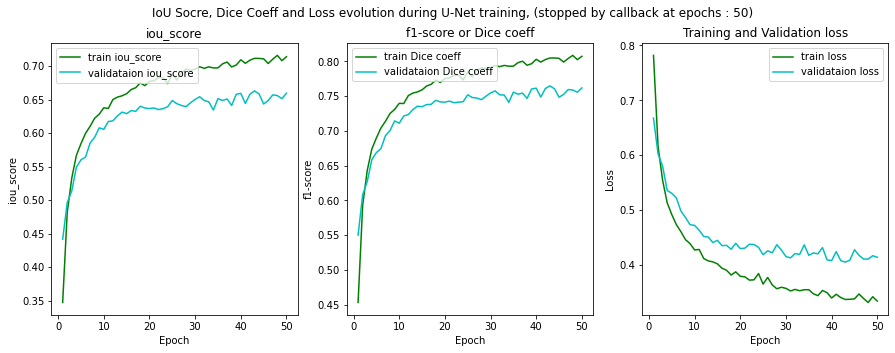

In [12]:
# Display learning curves 
#plot_history(model_test.history, model_test.name) #measures accuracy over epochs
#display_learning_curves_dice(model_test.history, model_test.name)#measures dice over epochs
#display_learning_curves_iou(model_test.history, model_test.name) #measures iou over epochs
display_learning_curves_iou_dice(model_test.history, model_test.name) #measures iou and dice over epochs

In [13]:
#saveResult("./results/val",results)
model_test.save('./Models/unetblock_Step2_CrossEntropy-JACCARD_IOU-DICE_model_256w_128h_1e-3lr_50epochs_NoAugment.h5')
#model_test.save('./Models/unet_model_512w_256h_1e-3lr_50epochs_Augment_CrossEntropy.h5')

#Load Model
#loss_function = total_loss
#model_test = keras.models.load_model('./Models/unetblock_Step2_CrossEntropy-JACCARD_IOU-DICE_model_256w_128h_1e-3lr_50epochs_NoAugment.h5', custom_objects={'total_loss': sm.losses.cce_jaccard_loss, 'f1-score':sm.metrics.FScore(), 'iou_score': sm.metrics.IOUScore()})


In [21]:
model_test.history.history

{}

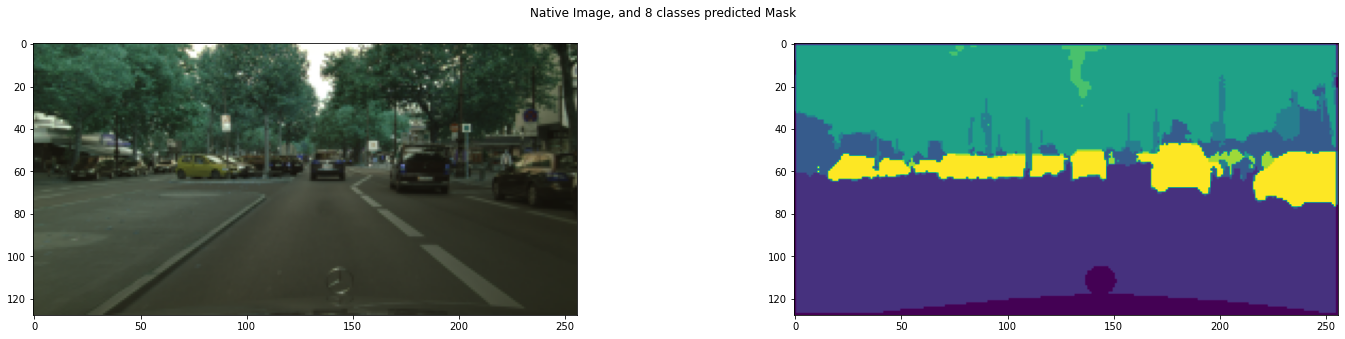

In [16]:
#Display Native Image, and 8 classes predicted Mask
picture_id = 1
batch_id = 0


masks = model_test.predict(test_generators[batch_id],verbose=0) #(np.expand_dims(img, axis=0), verbose=0)
mask = np.argmax(masks[picture_id], axis=2).astype(np.uint8)

images = test_generators[batch_id][0]
image = images[picture_id]

plt.figure(figsize=(25, 5))
plt.subplots_adjust(hspace=0.5)
plt.subplot(120 + 1 + 0)
plt.imshow(image)
plt.subplot(120 + 1 + 1)
plt.imshow(mask)
plt.grid(False)
plt.suptitle(f'Native Image, and 8 classes predicted Mask')
plt.show()


## Prédiction et Résumé des performances

Nous allons charger les modèles entrainés et sauvegardés, et mesurer ci-dessous les performances de chacun.
Nous les testerons sur les données de Val (car les données de tests ne contiennent pas de masques target)

In [17]:
test_generators = GeneratorCitySpace(clean_df, n_sample, batch_size, resize_width, resize_height, 'test', augmentation)
results = model_test.predict(test_generators,verbose=1)



305/305 [==============================] - 103s 338ms/step


ResourceExhaustedError: OOM when allocating tensor with shape[1525,128,256,8] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [23]:
loss_score, mean_iou_score = model_test.evaluate(data_val)
print("Le meilleur modèle obtient un score de :",mean_iou_score)
print("Le score final de la fonction loss est de :",loss_score)


In [ ]:
METRICS = [
    IOUScore(smooth=10e-12),
    FScore(beta=beta, smooth=10e-12),
]

LOSSES = [
    JaccardLoss(smooth=10e-12),
    DiceLoss(smooth=10e-12),
]

# Autres Architecture

Nous allons ci-dessous évaluer d'autres architectures, tels que:
 - UNET avec EfficientNet (Backbone)
 - UNET avec ResNet (Backbone)
 - [PSPNet](https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/models/pspnet.py) - Pyramid Scene Parsing Network
 - [FPN](https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/models/fpn.py)

Ici, nous allons utiliser les backbones contenant les poids pré-entrainés ([Voir Librairie](https://github.com/qubvel/segmentation_models)) sur le dataset ImageNet 2012 ILSVRC.

| Modèle | UNET | UNET EfficientNet | UNET RESNET | FPN |
|------------| ---- |-------|-------|-------------|
| **Total params** | 7,760,328 | xxx | xxx |  xxx |
| **Trainable params** | 7,760,328 | xxx | xxx | xxx |
| **Non-trainable params** | 0 | xxx | xxx |  xxx |

Nous évaluerons également l'apport de l'[augmentation d'images](https://albumentations.ai/docs/#introduction-to-image-augmentation).

In [ ]:
plot_history(history,scoring=["mean_iou","loss"],log_scale=[False,True])

In [ ]:
model_unet_resnet = sm.Unet('resnet34', classes=8, activation='softmax', encoder_weights='imagenet')
model_unet_efficientnet = sm.Unet('efficientnetb0', classes=8, activation='softmax', encoder_weights='imagenet')
model_PSPNet = sm.PSPNet() #A Verifier
model_FPN = sm.FPN()  #A Verifier

# if you set input channels not equal to 3, you have to set encoder_weights=None
# how to handle such case with encoder_weights='imagenet' described in docs
#model = Unet('resnet34', input_shape=(None, None, 6), encoder_weights=None)
